<img style="float:left;margin-left: -12px; margin-top: -10px" src="yelp-logo-27.png"  width=50>
# Fitness Classes NYC Recommender System

Now that we have scraped reviews for 1000 companies, we can being creating the recommender system. In this notenbook we will be building it out using the python library _**Surprise**_. We will try out different baseline models to determine find out which algorithm performs best with our data set.

The first step in this process, however is to start with EDA or exploratory data analysis. We will look at the distributions of our data so we can remove rows/reviews/businesses that do not serve us.

Steps:
1. **Read in our pickled dataset**
2. **Drop Places Outside of NYC**
3. **EDA:**
    - look into how many users we have
    - look at the distributions of ratings
    - avg star rating for each business
    - Num of reviews for each biz. and that distribution.
    - sorted list of the businesses with the most reviews
    - Location distribution
    - rating distribution by user (on avg how many reviewrs did each user leave)
    - Count of how many reviews each user left: sort the list show the top
<br><br>
4. **Drop Businesses with very few reviews**

__Read in needed libraries:__

In [157]:
import pickle
import numpy as np 
import pandas as pd
from Mod_5_functions import pickle_file,open_pickle,in_nyc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


__Import the pickled dataset & save as a DataFrame:__

In [2]:
pickle_in = open("Data/reviews_newest_523","rb")
example_dict = pickle.load(pickle_in)
start_reviews_df = pd.DataFrame(example_dict)

In [129]:
start_reviews_df.head(2)

,comapny_source,company_loc,rev_comp_rating,rev_comp_reviews,rev_comp_url,rev_company_name,userUrl,in_NYC
0,Peloton,"370 Canal St New York, NY 10013",3.0,"Planet Fitness is an affordable, no frills gym...",https://www.yelp.com/biz/planet-fitness-manhat...,Planet Fitness - Manhattan - Canal St - NY,https://www.yelp.com/user_details?userid=exPhu...,1
1,Peloton,"90 E 10th St New York, NY 10003",2.0,I purchased a Groupon for a friend and I. When...,https://www.yelp.com/biz/montauk-salt-cave-new...,Montauk Salt Cave,https://www.yelp.com/user_details?userid=exPhu...,1


### Exploratory Data Analysis:

__1. Total Count of Users:__

In [120]:
user_count = len(set(start_reviews_df['userUrl']))
business_count= len(set(start_reviews_df['rev_company_name']))
source_companies = len(set(start_reviews_df['comapny_source']))
print(f'There are {user_count} users for {business_count} total businesses reviewed')

There are 3831 users for 3446 total businesses reviewed


__SO, what *does* this mean?__ The difference in the number of users vs. the number of businesses has an impact on the type of CF recommender system we choose. Due to the users count and the business count being fairly similar we will be using the __user-user collaborative fitering__ method.

Had our **item** (business) count **far outweighed our users**, then it would have been an **item-item collaborative fitering** method.

__2. Distributions of ratings:__

/Users/elenasm7/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


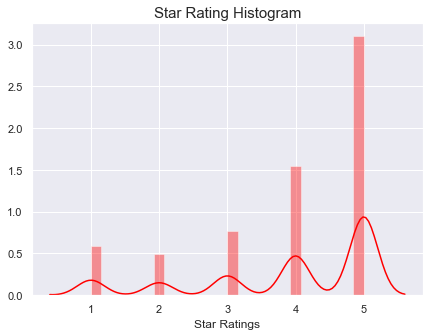

In [255]:
sns.set_style("darkgrid")
plt.figure(figsize=(7,5))
sns.distplot(start_reviews_df['rev_comp_rating'],norm_hist=False,color='red')
plt.title('Star Rating Histogram',fontsize=15)
plt.xlabel('Star Ratings')
sns.set(font_scale=1)
plt.savefig("Graphs/Orig_rating_dist.png")

Bar chart of value counts for star ratings:

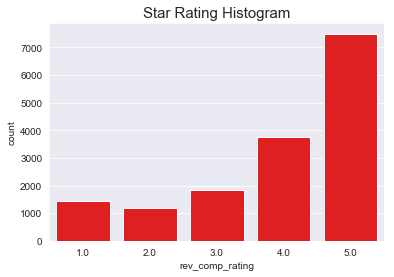

In [6]:
sns.countplot(start_reviews_df['rev_comp_rating'],color='red')
plt.title('Star Rating Histogram',fontsize=15);
# sns.set(font_scale=1)

Becuase of the clear positive skew we will need to deal with the class imbalance before creating our models. We will introduce this in the next notebook on NLP.

__3. Avg star rating for businesses__

/Users/elenasm7/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


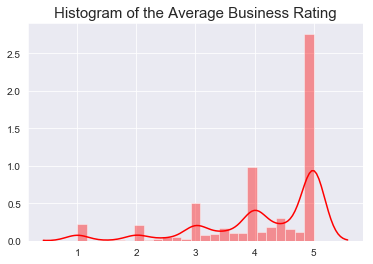

In [7]:
sns.distplot(start_reviews_df.groupby(['rev_company_name']).mean(),color='red')
plt.title('Histogram of the Average Business Rating',fontsize=15);

/Users/elenasm7/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


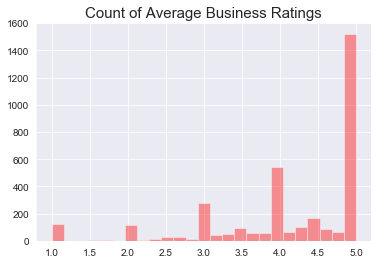

In [8]:
sns.distplot(start_reviews_df.groupby(['rev_company_name']).mean(),color='red',kde=False)
plt.title('Count of Average Business Ratings',fontsize=15);

Ok, after exploring the data it looks like there are multiple studios outside of New York. One interesting item is  the 'Las Vegas Athletic Club'. Although, all of our users are from NYC multiple users have been to this gym in Navada.

In [128]:
start_reviews_df[start_reviews_df['rev_company_name']=='Las Vegas Athletic Club'].head(2)

In [123]:
start_reviews_df['in_NYC'] = start_reviews_df.company_loc.apply(lambda x: in_nyc(x))
reviews_filtered_df_new = start_reviews_df[start_reviews_df.in_NYC == 1].drop(['in_NYC'],axis=1).reset_index(drop=True)

So, above we can see that there are multiple studios/gyms outside nyc and others that have closed or moved. However, becuse we are doing Item-Item we will keep these for now to help with our users ratings. One thing to consider is that we will not use these if we include location in one of our models. Further, when we give recommendations these will be dropped.

In [150]:
13598/15722

0.8649026841368782

In [148]:
print(f'shape before dropping rows: {start_reviews_df.shape}',
      f'shape after: {reviews_filtered_df_new.shape}',sep='\n........ YAS :) .......\n')

shape before dropping rows: (15722, 8)
........ YAS :) .......
shape after: (13598, 7)


**Becuase we just dropped business, some users may not have more than 1 review now. So, lets drop users with less than 1 place reviewed:**

In [143]:
users_filter = reviews_filtered_df_new.groupby('userUrl').filter(lambda x: len(x) > 1)

__Numer of reviews for each business:__

In [130]:
users_filter.rev_company_name.value_counts()[:10] 

New York Sports Clubs             506
Physique 57                       110
Peloton                            96
Yoga to the People                 92
Mile High Run Club                 86
New York Sports Clubs - CLOSED     81
Pop Physique                       79
305 Fitness                        72
Fhitting Room                      67
Brooklyn Boulders                  67
Name: rev_company_name, dtype: int64

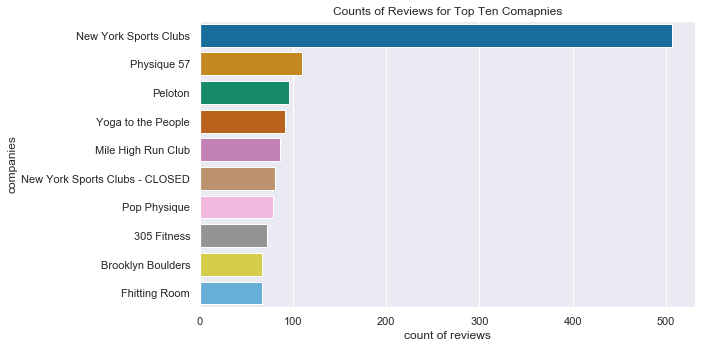

In [138]:
plt.figure(figsize=(10,5))
ax = sns.barplot(y=reviews_filtered_df.rev_company_name.value_counts().index[:10],
            x=reviews_filtered_df.rev_company_name.value_counts().values[:10],palette='colorblind')
plt.title('Counts of Reviews for Top Ten Comapnies',fontsize=12)
ax.set(xlabel='count of reviews', ylabel='companies')
sns.set(font_scale=1)
plt.tight_layout()
plt.savefig("review_count_top_10.png");

__Distribution of the review counts:__

We can see that the distribution has a heavily __negative skew__.

/Users/elenasm7/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


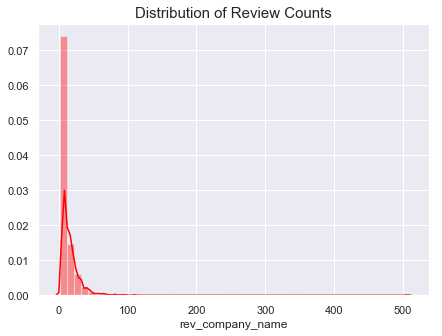

In [139]:
plt.figure(figsize=(7,5))
sns.distplot(reviews_filtered_df.rev_company_name.value_counts(),color='red')
plt.title('Distribution of Review Counts',fontsize=15);

__Location Distributions__: 

We will use the Google API to get all of the latitude and longitudes from our addresses. If you're interested in using the google api, then check out their python client libray [here](https://github.com/googlemaps/google-maps-services-python). 


In [151]:
filtered_addresses = list(set(users_filter.company_loc))

In [152]:
all_addresses = list(set(start_reviews_df.company_loc))

In [153]:
print(f'length of filtered addresses: {len(filtered_addresses)}',
      f'length of all addresses: {len(all_addresses)}',sep='\n')

length of filtered addresses: 1841
length of all addresses: 3673


In [234]:
import googlemaps
import time

# gmaps = googlemaps.Client(key='Your API Key')

# #Geocoding an address
# comp_coord_tupe = []
# for add in all_addresses:
#     time.sleep(0.25)
#     comp_coord_tupe.append((gmaps.geocode(add),add))

comp_coord_tupe_new = []

for i in comp_coord_tupe:
    try:
        lat = float(i[0][0]['geometry']['location']['lat'])
        long = float(i[0][0]['geometry']['location']['lng'])
        comp_coord_tupe_new.append(([lat,long],i[1]))
    except: 
        continue
                                 

In [246]:
here = []
for i in comp_coord_tupe_new:
    here.append(i[1])


In [239]:
pickle_file(comp_coord_tupe_new,'company_addres_coord')

'Pickled object!'

In [251]:
map_plot = folium.Map(location = [38.9, -77.05], zoom_start=5, tiles = "Mapbox bright")
feature_group = folium.FeatureGroup("Locations")

for point in range(0, len(comp_coord_tupe_new[:1000])):
    feature_group.add_child(folium.Marker(location=comp_coord_tupe_new[point][0],popup=comp_coord_tupe_new[point][1]))

map_plot.add_child(feature_group)
map_plot

__Users averge Ratings and Distributions__:


rating distribution by user (on avg how many reviewrs did each user leave). So, due to us doing collaborative fitering we do not need each user to have left multiple reviews, but we do need them to have left one. Good for us that the majority of people left 2 or more.

/Users/elenasm7/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


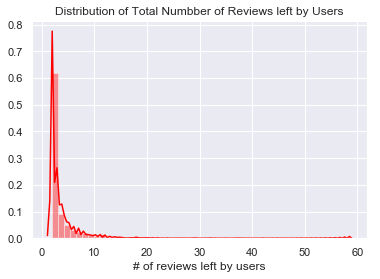

In [252]:
sns.distplot(users_filter.groupby('userUrl').count()['rev_company_name'],color='red')
plt.xlabel('# of reviews left by users')
plt.title('Distribution of Total Numbber of Reviews left by Users');
# plt.setp(ax.get_xticklabels()[:17], rotation=90);

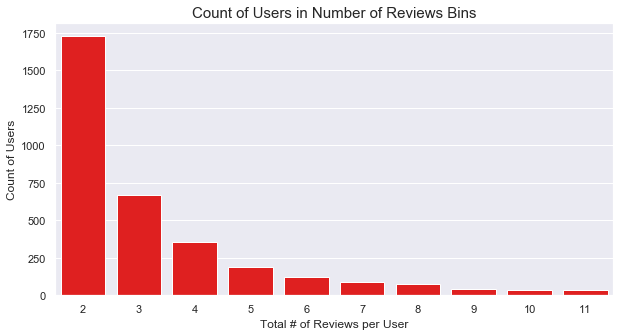

In [253]:
plt.figure(figsize=(10,5))
data = users_filter.groupby('userUrl').count().rev_company_name.value_counts()[:10]
ax = sns.barplot(x=data.index, y=data.values,color='red')
plt.title('Count of Users in Number of Reviews Bins',fontsize=15)
plt.xlabel('Total # of Reviews per User')
plt.ylabel('Count of Users');

In [22]:
#pickle this DataFrame
users_filter.to_pickle("Data/filtered_user_data.pkl")

Continue to the NLP section to continue data cleaning for the text data:

Section 2: NLP and Text Cleaning:
5. **Data Preprocessing**
6. **Dealing with Class Imbalance**
7. **Train-Test Split**
